Importamos las librerías necesarias

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import cornac
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, Precision, MAE, RMSE
from cornac.models import ItemKNN, BPR, MF, SVD
from cornac.models import Recommender
from surprise import SVD
from cornac.eval_methods import RatioSplit

Crear modelos propios

In [76]:
class MeanRecommender(Recommender):
    def __init__(self, name="MeanRecommender"):
        super().__init__(name=name)
        self.item_means = None

    def fit(self, train_set, val_set):
        super().fit(train_set, val_set)
        # Calcular la media de las calificaciones para cada ítem
        self.item_means = np.zeros(train_set.num_items)
        for i in range(train_set.num_items):
            ratings = train_set.matrix[:, i].data
            if len(ratings) > 0:
                self.item_means[i] = np.mean(ratings)
            else:
                self.item_means[i] = 0

    def score(self, user_id, item_id=None):
        if item_id is None:
            return self.item_means
        return self.item_means[item_id]
    
class Hybrid(cornac.models.Recommender):
    def __init__(self, models, weights, name="Hybrid"):
        super().__init__(name=name)
        self.models = models
        self.weights = weights

    def fit(self, train_set, eval_set):
        super().fit(train_set,eval_set)
        for m in self.models:
            m.fit(train_set, eval_set)

    def score(self, user_idx, item_idx=None):
        ponderated_sum = 0
        # if each weight is 1/len(weights) is the average  
        for idx in range(len(self.models)):
            ponderated_sum += self.models[idx].score(user_idx, item_idx)*self.weights[idx]

        return ponderated_sum/sum(self.weights)


Cargar el dataset de MovieLens 100K

In [77]:
data = movielens.load_feedback()

Definir el método de evaluación

In [78]:
ratio_split = RatioSplit(data=data, test_size=0.2, rating_threshold=4.0, exclude_unknowns=True, verbose=True)

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1645
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1645
Number of ratings = 19952
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1645


Definir los modelos a emplear

In [79]:
mean_recommender = MeanRecommender() # Modelo propio
mf = MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
svd = cornac.models.SVD()
knn = ItemKNN(k=20, similarity='cosine', name='ItemKNN')
bpr = cornac.models.BPR(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
hybrid = Hybrid([mf, knn], (10,1))


Definir las metricas a utilizar

In [80]:
metrics = []
metrics.append(MAE())
metrics.append(RMSE())
metrics.append(Recall(10))
metrics.append(Precision(10))

Definir el experimento


In [81]:
experiment = cornac.Experiment(eval_method=ratio_split, models=[mean_recommender, mf, bpr, svd, knn, hybrid], metrics=metrics)

Ejecutar el experimento

In [82]:
experiment.run()


[MeanRecommender] Training started!

[MeanRecommender] Evaluation started!


Rating:   0%|          | 0/19952 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/19952 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Rating:   0%|          | 0/19952 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[SVD] Training started!

[SVD] Evaluation started!


Rating:   0%|          | 0/19952 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[ItemKNN] Training started!


  0%|          | 0/1645 [00:00<?, ?it/s]


[ItemKNN] Evaluation started!


Rating:   0%|          | 0/19952 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[Hybrid] Training started!


  0%|          | 0/1645 [00:00<?, ?it/s]


[Hybrid] Evaluation started!


Rating:   0%|          | 0/19952 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


TEST:
...
                |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) | Test (s)
--------------- + ------ + ------ + ------------ + --------- + --------- + --------
MeanRecommender | 0.8343 | 0.9948 |       0.0003 |    0.0004 |    0.5040 |   0.8316
MF              | 0.7438 | 0.9009 |       0.0692 |    0.0503 |    0.0485 |   1.5378
BPR             | 2.1582 | 2.3559 |       0.1136 |    0.1189 |    0.1490 |   2.2069
SVD             | 0.7495 | 0.9066 |       0.0598 |    0.0423 |    0.0880 |   1.1667
ItemKNN         | 0.8227 | 0.9956 |       0.0251 |    0.0163 |    0.1503 |   7.0309
Hybrid          | 0.7540 | 0.9211 |       0.0669 |    0.0562 |    0.2056 |   6.9077



Extraer los resultados de las métricas

In [83]:
results = experiment.result
mean_mae = results[0].metric_avg_results['MAE']
mean_rmse = results[0].metric_avg_results['RMSE']
mean_precision = results[0].metric_avg_results['Precision@10']
mf_mae = results[1].metric_avg_results['MAE']
mf_rmse = results[1].metric_avg_results['RMSE']
mf_precision = results[1].metric_avg_results['Precision@10']
bpr_mae = results[2].metric_avg_results['MAE']
bpr_rmse = results[2].metric_avg_results['RMSE']
bpr_precision = results[2].metric_avg_results['Precision@10']
svd_mae = results[3].metric_avg_results['MAE']
svd_rmse = results[3].metric_avg_results['RMSE']
svd_precision = results[3].metric_avg_results['Precision@10']
knn_mae = results[4].metric_avg_results['MAE']
knn_rmse = results[4].metric_avg_results['RMSE']
knn_precision = results[4].metric_avg_results['Precision@10']

Crear un gráfico de barras para mostrar los resultados

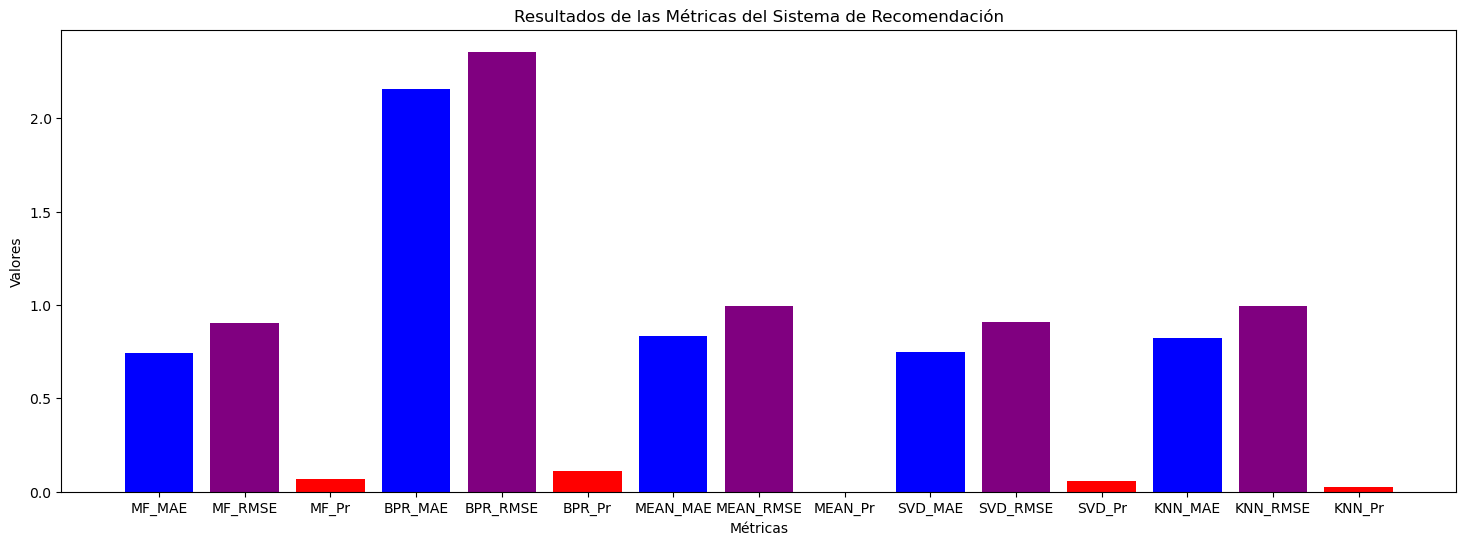

In [84]:
metrics_names = ['MF_MAE', 'MF_RMSE', 'MF_Pr', 'BPR_MAE', 'BPR_RMSE', 'BPR_Pr', 'MEAN_MAE', 'MEAN_RMSE', 'MEAN_Pr', 'SVD_MAE', 'SVD_RMSE', 'SVD_Pr', 'KNN_MAE', 'KNN_RMSE', 'KNN_Pr']
values = [mf_mae, mf_rmse, mf_precision, bpr_mae, bpr_rmse, bpr_precision, mean_mae, mean_rmse, mean_precision, svd_mae, svd_rmse, svd_precision, knn_mae, knn_rmse, knn_precision] 

plt.figure(figsize=(18, 6))
plt.bar(metrics_names, values, color=['blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Resultados de las Métricas del Sistema de Recomendación')
plt.show()
